__Newsreader, Topic Modeling and Sentiment Analysis__

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

import newspaper
from newspaper import Article
import requests
import urllib.request

from sklearn import cluster
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from wordcloud import WordCloud

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

import nltk
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('de_core_news_md')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuelfreistein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

__Newsreader__

Data for the newsreader was taken from the German newspapers SPIEGEL, STERN, SÜDDEUTSCHE ZEITUNG and BERLINER ZEITUNG. Using the newspapers' RSS feeds, relevant URLs were extracted with BeautifulSoup. The articles themselves were downloaded with Python's Newspaper module. The data was assembled in a Pandas dataframe. Columns included author's names, article titles, dates published, summaries, keywords and text. SPIEGEL articles with restricted access were not included in order to avoid skewing later analysis results.  

In [358]:
feeds = ["https://www.spiegel.de/schlagzeilen/index.rss", "https://www.stern.de/feed/standard/all/", "https://rss.sueddeutsche.de/app/service/rss/alles/index.rss?output=rss", "https://www.berliner-zeitung.de/feed.xml"]


df_newspaper = pd.DataFrame(columns = ["authors", "title", "date published", "summary", "keywords", "text"])
                                       
        
for feed in feeds:        
    response = requests.get(feed)
    webpage = response.content
    soup = BeautifulSoup(webpage, features = "xml")
    items = soup.find_all("item")
    articles = []
    
    for item in items:
        link = item.find("link").text
        articles.append(link)

    for url in articles:
        article = Article(url)
        article.download()
        article.parse()
        article.nlp()
        if "SPIEGEL+-Zugang" in article.summary:
            continue
        authors = article.authors
        title = article.title
        date_published = article.publish_date
        summary = article.summary
        keywords = article.keywords
        keywords = ' '.join([str(elem) for elem in keywords])
        text = article.text
        row = [authors, title, date_published, summary, keywords, text]
        df_newspaper.loc[len(df_newspaper)] = row


print(len(df_newspaper))
df_newspaper.head(10)


154


,authors,title,date published,summary,keywords,text
0,"[Peter Ahrens, Der Spiegel]",Tour de France 2022 in den Pyrenäen: Die vorle...,None,Mal ging es an diesem Tag über den mächtigen C...,und er dem war tour 2022 den chance vorletzte ...,In alter Tradition: Zum sage und schreibe 75. ...
1,"[Wolfgang Höbel, Der Spiegel]","News des Tages: Nord Stream 1, Gasturbine, Rek...",None,Die Konstellation wirke »praktisch als Europas...,stream wedel und dieter er des der gasturbine ...,Die Konstellation wirke »praktisch als Europas...
2,[Der Spiegel],Michael Kretschmer: Unterstützung von Linken u...,None,"AfD-Chef Tino Chrupalla erklärte, Kretschmer s...",unterstützung michael und csu mit ist chrupall...,"AfD-Chef Tino Chrupalla erklärte, Kretschmer s..."
3,"[Barbara Erbe, Der Spiegel]",Ernährungskrise: Es liegt am Fleisch- und Spri...,None,"Wahr ist aber auch, dass sich die Ernährungsla...",und dem auch sind der länder es sprithunger ni...,"Wahr ist aber auch, dass sich die Ernährungsla..."
4,[Der Spiegel],Deutsche Bahn zieht Diesel-Aus im Fernverkehr ...,None,Die Bahn hat sich das Ziel gesteckt bis 2040 k...,dieselaus deutsche mit 2025 komplett auch zunä...,Die Bahn hat sich das Ziel gesteckt bis 2040 k...
5,[Der Spiegel],Iris Apfel: Bildband über ihr Leben,None,"Freier Zugang zu allen Artikeln, Videos, Audio...",ihr und dem mit um iris über leben bildband zu...,"Freier Zugang zu allen Artikeln, Videos, Audio..."
6,[Der Spiegel],Nord Stream 1: Warum Russland ab Donnerstag wi...,None,"Bei 40 Prozent Lieferungen durch Nord Stream, ...",um die auf stream dem der prozent nord wieder ...,"Bei 40 Prozent Lieferungen durch Nord Stream, ..."
7,"[Sabrina Knoll, Der Spiegel]",Wie Alexandria Ocasio-Cortez ihren Aktivismus ...,None,"Es ist, wenn man so will, eine Spezialität von...",kritik hat wie mit ummünzt abgeordnete auch de...,"Es ist, wenn man so will, eine Spezialität von..."
8,[Der Spiegel],Großbritannien – Boris-Johnson-Nachfolge: Liz ...,None,Sunak und Truss treten damit in einer Stichwah...,übernimmt und großbritannien rishi truss johns...,Sunak und Truss treten damit in einer Stichwah...
9,[Der Spiegel],Tour de France 2022: Jonas Vingegaard und Tade...,None,Derweil werden Simon Geschkes Träume von der F...,die und dominieren von der noch jonas geschkes...,Derweil werden Simon Geschkes Träume von der F...


__Cleaning and Preparing Data__

To get the best possible topic modelling and sentiment analysis results, the data had to be cleaned. Firstly, the articles were lemmatized. Secondly, Natural Language Toolkit stopwords were removed. Furthermore, short words (less than three letters) as well as a selection of words with extremely high reoccurance rate throughout all articles were removed, because they distorted the results of the implemented topic models.

A wordcloud enabled a quick understanding of the occurences of certain words. It was helpful in improving the cleaning steps.

In [359]:
df_newspaper['text'] = df_newspaper['text'].apply(lambda text: ' '.join([x.lemma_ for x in nlp(text)]))
#df_newspaper['text'] = df_newspaper['text'].map(lambda x: re.sub('[,\.!?;:-]', ' ', x))
df_newspaper['text'] = df_newspaper['text'].map(lambda x: re.sub(' | '.join(stopwords.words('german')), ' ', x))
df_newspaper['text'] = df_newspaper['text'].map(lambda x: re.sub('geben|sollen|sagen|werden|haben', ' ', x))
df_newspaper['text'] = df_newspaper['text'].apply(lambda text: [word for word in text.split() if len(word)>3])
df_newspaper['text'] = [' '.join(map(str, word)) for word in df_newspaper['text']]
df_newspaper['authors'] = [', '.join(map(str, word)) for word in df_newspaper['authors']]

df_newspaper.head(10)

,authors,title,date published,summary,keywords,text
0,"Peter Ahrens, Der Spiegel",Tour de France 2022 in den Pyrenäen: Die vorle...,None,Mal ging es an diesem Tag über den mächtigen C...,und er dem war tour 2022 den chance vorletzte ...,Tradition schreiben gehen mächtig d'Aspin myth...
1,"Wolfgang Höbel, Der Spiegel","News des Tages: Nord Stream 1, Gasturbine, Rek...",None,Die Konstellation wirke »praktisch als Europas...,stream wedel und dieter er des der gasturbine ...,Konstellation wirken praktisch Europa Wärmepum...
2,Der Spiegel,Michael Kretschmer: Unterstützung von Linken u...,None,"AfD-Chef Tino Chrupalla erklärte, Kretschmer s...",unterstützung michael und csu mit ist chrupall...,AfD-Chef Tino Chrupalla erklären Kretschmer sc...
3,"Barbara Erbe, Der Spiegel",Ernährungskrise: Es liegt am Fleisch- und Spri...,None,"Wahr ist aber auch, dass sich die Ernährungsla...",und dem auch sind der länder es sprithunger ni...,Wahr auch sich Ernährungslage Welt bereits Ang...
4,Der Spiegel,Deutsche Bahn zieht Diesel-Aus im Fernverkehr ...,None,Die Bahn hat sich das Ziel gesteckt bis 2040 k...,dieselaus deutsche mit 2025 komplett auch zunä...,Bahn sich Ziel stecken 2040 komplett klimaneut...
5,Der Spiegel,Iris Apfel: Bildband über ihr Leben,None,"Freier Zugang zu allen Artikeln, Videos, Audio...",ihr und dem mit um iris über leben bildband zu...,Freier Zugang aller Artikel Video Audioinhalt ...
6,Der Spiegel,Nord Stream 1: Warum Russland ab Donnerstag wi...,None,"Bei 40 Prozent Lieferungen durch Nord Stream, ...",um die auf stream dem der prozent nord wieder ...,Prozent Lieferung Nord Stream Wartung Deutschl...
7,"Sabrina Knoll, Der Spiegel",Wie Alexandria Ocasio-Cortez ihren Aktivismus ...,None,"Es ist, wenn man so will, eine Spezialität von...",kritik hat wie mit ummünzt abgeordnete auch de...,wollen Spezialität Ocasio-Cortez progressiv ab...
8,Der Spiegel,Großbritannien – Boris-Johnson-Nachfolge: Liz ...,None,Sunak und Truss treten damit in einer Stichwah...,übernimmt und großbritannien rishi truss johns...,Sunak Truss treten Stichwahl gegeneinander Erg...
9,Der Spiegel,Tour de France 2022: Jonas Vingegaard und Tade...,None,Derweil werden Simon Geschkes Träume von der F...,die und dominieren von der noch jonas geschkes...,derweil Simon Geschkes Traum Fahrt Bergtrikot ...


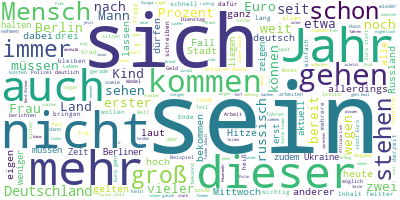

In [360]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
long_string = ','.join(list(df_newspaper['text'].values))
wordcloud.generate(long_string)
wordcloud.to_image()

__Sentiment analyisis__

A couple of different sentiment analyses were performed on the article texts using the TextBlob, vader and BERT transformer (trained for product reviews in several languages including German). The scores were included in the dataframe.

In [361]:
sid_obj = SentimentIntensityAnalyzer()

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentimentAnalysis_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

df_newspaper['textblob'] = ""
df_newspaper['vader'] = ""
df_newspaper['bert-base-multilingual-uncased-sentiment'] = ""

for i in range(0,len(df_newspaper['text'])):
    text = df_newspaper['text'].iloc[i]
    df_newspaper.at[i, 'textblob'] = "Polarity: "+str(TextBlob(text).polarity)+", Subjectivity: "+str(TextBlob(text).subjectivity)
    df_newspaper.at[i, 'vader'] = sid_obj.polarity_scores(text)
    df_newspaper.at[i, 'bert-base-multilingual-uncased-sentiment'] = text[:512]
    df_newspaper.at[i, 'bert-base-multilingual-uncased-sentiment'] = sentimentAnalysis_pipeline(df_newspaper['bert-base-multilingual-uncased-sentiment'].iloc[i])
    df_newspaper.at[i, 'bert-base-multilingual-uncased-sentiment'] = str(df_newspaper.at[i, 'bert-base-multilingual-uncased-sentiment'][0]['label'])+" "+str(round(df_newspaper.at[i, 'bert-base-multilingual-uncased-sentiment'][0]['score'], 6))
    
df_newspaper.head(10)

,authors,title,date published,summary,keywords,text,textblob,vader,bert-base-multilingual-uncased-sentiment
0,"Peter Ahrens, Der Spiegel",Tour de France 2022 in den Pyrenäen: Die vorle...,None,Mal ging es an diesem Tag über den mächtigen C...,und er dem war tour 2022 den chance vorletzte ...,Tradition schreiben gehen mächtig d'Aspin myth...,"Polarity: 0.06666666666666667, Subjectivity: 0.6","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4 stars 0.295631
1,"Wolfgang Höbel, Der Spiegel","News des Tages: Nord Stream 1, Gasturbine, Rek...",None,Die Konstellation wirke »praktisch als Europas...,stream wedel und dieter er des der gasturbine ...,Konstellation wirken praktisch Europa Wärmepum...,"Polarity: -0.2, Subjectivity: 0.6","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",3 stars 0.328165
2,Der Spiegel,Michael Kretschmer: Unterstützung von Linken u...,None,"AfD-Chef Tino Chrupalla erklärte, Kretschmer s...",unterstützung michael und csu mit ist chrupall...,AfD-Chef Tino Chrupalla erklären Kretschmer sc...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.60819
3,"Barbara Erbe, Der Spiegel",Ernährungskrise: Es liegt am Fleisch- und Spri...,None,"Wahr ist aber auch, dass sich die Ernährungsla...",und dem auch sind der länder es sprithunger ni...,Wahr auch sich Ernährungslage Welt bereits Ang...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.655411
4,Der Spiegel,Deutsche Bahn zieht Diesel-Aus im Fernverkehr ...,None,Die Bahn hat sich das Ziel gesteckt bis 2040 k...,dieselaus deutsche mit 2025 komplett auch zunä...,Bahn sich Ziel stecken 2040 komplett klimaneut...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.262098
5,Der Spiegel,Iris Apfel: Bildband über ihr Leben,None,"Freier Zugang zu allen Artikeln, Videos, Audio...",ihr und dem mit um iris über leben bildband zu...,Freier Zugang aller Artikel Video Audioinhalt ...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.59384
6,Der Spiegel,Nord Stream 1: Warum Russland ab Donnerstag wi...,None,"Bei 40 Prozent Lieferungen durch Nord Stream, ...",um die auf stream dem der prozent nord wieder ...,Prozent Lieferung Nord Stream Wartung Deutschl...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.487492
7,"Sabrina Knoll, Der Spiegel",Wie Alexandria Ocasio-Cortez ihren Aktivismus ...,None,"Es ist, wenn man so will, eine Spezialität von...",kritik hat wie mit ummünzt abgeordnete auch de...,wollen Spezialität Ocasio-Cortez progressiv ab...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'comp...",1 star 0.436946
8,Der Spiegel,Großbritannien – Boris-Johnson-Nachfolge: Liz ...,None,Sunak und Truss treten damit in einer Stichwah...,übernimmt und großbritannien rishi truss johns...,Sunak Truss treten Stichwahl gegeneinander Erg...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.79763
9,Der Spiegel,Tour de France 2022: Jonas Vingegaard und Tade...,None,Derweil werden Simon Geschkes Träume von der F...,die und dominieren von der noch jonas geschkes...,derweil Simon Geschkes Traum Fahrt Bergtrikot ...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.035, 'neu': 0.965, 'pos': 0.0, 'comp...",3 stars 0.289331


__Topic Modelling__

In order to achieve meaningful topic modeling results, three different unsupervised machine learning algorithms from the Scikit-learn library were fitted to the data (LatentDirichletAllocation (LDA), KMeans, MiniBatchKMeans) and compared to each other. Scikit-learn's count vectorizer was used in combination with LDA, while KMeans and MiniBatchKMeans used the TfidfVectorizer. For each approach, hyperparameters were tuned with the help of GridSearch (including n_components, n_clusters and learning_decay). Log Likelihood Scores allowed for a first comparison between the methods. LDA always scored lower than the other two methods.

In [362]:
lda_search_params = {'n_components': [3, 5, 10], 'learning_decay': [.5, .7, .9]}
vectorizer_lda_gridsearch = CountVectorizer()
lda_gridsearch = LatentDirichletAllocation()
model_gridsearch_lda = GridSearchCV(lda_gridsearch, param_grid=lda_search_params)
vectorized_gridsearch_lda = vectorizer_lda_gridsearch.fit_transform(df_newspaper['text']).toarray()
model_gridsearch_lda.fit(vectorized_gridsearch_lda)

best_lda_model = model_gridsearch_lda.best_estimator_
print("LDA Best Model's Params: ", model_gridsearch_lda.best_params_)
print("LDA Best Log Likelihood Score: ", model_gridsearch_lda.best_score_)

LDA Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
LDA Best Log Likelihood Score:  -90036.2747486659


In [365]:
vectorizer_lda = CountVectorizer()
lda = LatentDirichletAllocation(learning_decay = 0.5, n_components = 3)
vectorized_lda = vectorizer_lda.fit_transform(df_newspaper['text'])
lda.fit(vectorized_lda)

LatentDirichletAllocation(learning_decay=0.5, n_components=3)

In [366]:
df_newspaper['cluster_assignment LDA'] = ""

for i in range(0,len(df_newspaper['text'])):
    text = [df_newspaper['text'].iloc[i]]
    vectorized_text_lda = vectorizer_lda.transform(text)
    doc_topic_dist = np.matrix(lda.transform(vectorized_text_lda))
    df_newspaper.at[i, 'cluster_assignment LDA'] = np.argmax(doc_topic_dist)

In [363]:
kmeans_search_params = {'n_init': [10, 100], 'n_clusters': [3, 5, 10], 'algorithm': ['auto', 'full', 'elkan']}
vectorizer_KMeans = TfidfVectorizer()
kmeans_gridsearch =  KMeans()
model_gridsearch_kmeans = GridSearchCV(kmeans_gridsearch, param_grid=kmeans_search_params)
vectorized_gridsearch_kmeans = vectorizer_KMeans.fit_transform(df_newspaper['text']).toarray()
model_gridsearch_kmeans.fit(vectorized_gridsearch_kmeans)

best_kmeans_model = model_gridsearch_kmeans.best_estimator_
print("KMeans Best Model's Params: ", model_gridsearch_kmeans.best_params_)
print("KMeans Best Log Likelihood Score: ", model_gridsearch_kmeans.best_score_)

KMeans Best Model's Params:  {'algorithm': 'elkan', 'n_clusters': 3, 'n_init': 100}
KMeans Best Log Likelihood Score:  -30.160382169070367


In [367]:
text_clustering_KMeans = Pipeline([('vect', TfidfVectorizer()), ('clustering', KMeans(algorithm = 'elkan' , n_clusters = 3, n_init = 100))])
text_clustering_KMeans.fit(df_newspaper['text'])
df_newspaper['cluster_assignment KMeans'] = text_clustering_KMeans.predict(df_newspaper['text'])

In [364]:
MiniBatchKMeans_search_params = {'n_init': [10, 100], 'n_clusters': [3, 5, 10], 'reassignment_ratio': [0, 0.001, 0.01]}
vectorizer_MiniBatchKMeans = TfidfVectorizer()
MiniBatchKMeans_gridsearch =  MiniBatchKMeans()
model_gridsearch_MiniBatchKMeans = GridSearchCV(MiniBatchKMeans_gridsearch, param_grid=MiniBatchKMeans_search_params)
vectorized_gridsearch_MiniBatchKMeans = vectorizer_MiniBatchKMeans.fit_transform(df_newspaper['text']).toarray()
model_gridsearch_MiniBatchKMeans.fit(vectorized_gridsearch_MiniBatchKMeans)

best_MiniBatchKMeans_model = model_gridsearch_MiniBatchKMeans.best_estimator_
print("MiniBatchKMeans Best Model's Params: ", model_gridsearch_MiniBatchKMeans.best_params_)
print("MiniBatchKMeans Best Log Likelihood Score: ", model_gridsearch_MiniBatchKMeans.best_score_)

MiniBatchKMeans Best Model's Params:  {'n_clusters': 10, 'n_init': 100, 'reassignment_ratio': 0.001}
MiniBatchKMeans Best Log Likelihood Score:  -30.094990218963353


In [368]:
text_clustering_MiniBatchKMeans = Pipeline([('vect', TfidfVectorizer()), ('clustering', MiniBatchKMeans(n_init = 100, n_clusters = 10, reassignment_ratio = 0.001))])
text_clustering_MiniBatchKMeans.fit(df_newspaper['text'])
df_newspaper['cluster_assignment MiniBatchKMeans'] = text_clustering_MiniBatchKMeans.predict(df_newspaper['text'])

In [369]:
df_newspaper.head(n=10)

,authors,title,date published,summary,keywords,text,textblob,vader,bert-base-multilingual-uncased-sentiment,cluster_assignment LDA,cluster_assignment KMeans,cluster_assignment MiniBatchKMeans
0,"Peter Ahrens, Der Spiegel",Tour de France 2022 in den Pyrenäen: Die vorle...,None,Mal ging es an diesem Tag über den mächtigen C...,und er dem war tour 2022 den chance vorletzte ...,Tradition schreiben gehen mächtig d'Aspin myth...,"Polarity: 0.06666666666666667, Subjectivity: 0.6","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4 stars 0.295631,2,2,5
1,"Wolfgang Höbel, Der Spiegel","News des Tages: Nord Stream 1, Gasturbine, Rek...",None,Die Konstellation wirke »praktisch als Europas...,stream wedel und dieter er des der gasturbine ...,Konstellation wirken praktisch Europa Wärmepum...,"Polarity: -0.2, Subjectivity: 0.6","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",3 stars 0.328165,2,1,8
2,Der Spiegel,Michael Kretschmer: Unterstützung von Linken u...,None,"AfD-Chef Tino Chrupalla erklärte, Kretschmer s...",unterstützung michael und csu mit ist chrupall...,AfD-Chef Tino Chrupalla erklären Kretschmer sc...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.60819,0,2,5
3,"Barbara Erbe, Der Spiegel",Ernährungskrise: Es liegt am Fleisch- und Spri...,None,"Wahr ist aber auch, dass sich die Ernährungsla...",und dem auch sind der länder es sprithunger ni...,Wahr auch sich Ernährungslage Welt bereits Ang...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.655411,1,2,5
4,Der Spiegel,Deutsche Bahn zieht Diesel-Aus im Fernverkehr ...,None,Die Bahn hat sich das Ziel gesteckt bis 2040 k...,dieselaus deutsche mit 2025 komplett auch zunä...,Bahn sich Ziel stecken 2040 komplett klimaneut...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.262098,0,2,5
5,Der Spiegel,Iris Apfel: Bildband über ihr Leben,None,"Freier Zugang zu allen Artikeln, Videos, Audio...",ihr und dem mit um iris über leben bildband zu...,Freier Zugang aller Artikel Video Audioinhalt ...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.59384,1,2,5
6,Der Spiegel,Nord Stream 1: Warum Russland ab Donnerstag wi...,None,"Bei 40 Prozent Lieferungen durch Nord Stream, ...",um die auf stream dem der prozent nord wieder ...,Prozent Lieferung Nord Stream Wartung Deutschl...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.487492,0,2,1
7,"Sabrina Knoll, Der Spiegel",Wie Alexandria Ocasio-Cortez ihren Aktivismus ...,None,"Es ist, wenn man so will, eine Spezialität von...",kritik hat wie mit ummünzt abgeordnete auch de...,wollen Spezialität Ocasio-Cortez progressiv ab...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'comp...",1 star 0.436946,1,2,7
8,Der Spiegel,Großbritannien – Boris-Johnson-Nachfolge: Liz ...,None,Sunak und Truss treten damit in einer Stichwah...,übernimmt und großbritannien rishi truss johns...,Sunak Truss treten Stichwahl gegeneinander Erg...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1 star 0.79763,2,1,5
9,Der Spiegel,Tour de France 2022: Jonas Vingegaard und Tade...,None,Derweil werden Simon Geschkes Träume von der F...,die und dominieren von der noch jonas geschkes...,derweil Simon Geschkes Traum Fahrt Bergtrikot ...,"Polarity: 0.0, Subjectivity: 0.0","{'neg': 0.035, 'neu': 0.965, 'pos': 0.0, 'comp...",3 stars 0.289331,2,2,5


__Analysis__

In order to analyze the results, the first ten terms of each method's word clusters were printed. In this way, adjustments could be made to the cleaning process. If certain words occured high on the list across clusters, thereby not contributing to differentiation between them, they were removed. Furthermore, it allowed for manual cross-checking article text with assigend topics in samples. 

Lastly, the distribution of articles across topics was printed out. The goal was to achieve at least a relatively even distribution across the clusters. 

In [370]:
cluster_words_lda = {}

for topic_idx, topic in enumerate(lda.components_):
    words_list_lda = []
    for i in topic.argsort()[:-10 - 1:-1]:
        words_list_lda.append(vectorizer_lda.get_feature_names_out()[i])
    cluster_words_lda[topic_idx] = words_list_lda
pd.DataFrame(cluster_words_lda)

,0,1,2
0,sein,sein,sein
1,euro,nicht,sich
2,jahr,auch,mehr
3,99,dieser,jahr
4,dieser,sich,euro
5,mehr,twitter,auch
6,nicht,inhalt,dieser
7,russisch,können,gehen
8,sich,mehr,berlin
9,kommen,jahr,kind


In [371]:
idx2word = {v:k for k,v in text_clustering_KMeans.steps[0][1].vocabulary_.items()}
cluster_centers_KMeans = text_clustering_KMeans.steps[1][1].cluster_centers_
cluster_words_KMeans = {}
for cluster_id, cluster_center in enumerate(cluster_centers_KMeans):
    cluster_words_KMeans[cluster_id] = [idx2word[idx] for idx in cluster_center.argsort()[-10:][::-1]]
print("topics KMeans")
pd.DataFrame(cluster_words_KMeans)

topics KMeans


,0,1,2
0,twitter,euro,sein
1,inhalt,hoch,jahr
2,anzeigen,feuer,prozent
3,drittanbieter,polizei,sich
4,sein,mann,mehr
5,hinweis,brand,nicht
6,stelle,mensch,dieser
7,personenbezogen,land,kommen
8,übermitteln,brandenburg,gehen
9,drittland,sich,russland


In [372]:
idx2word = {v:k for k,v in text_clustering_MiniBatchKMeans.steps[0][1].vocabulary_.items()}
cluster_centers_MiniBatchKMeans = text_clustering_MiniBatchKMeans.steps[1][1].cluster_centers_
cluster_words_MiniBatchKMeans = {}
for cluster_id, cluster_center in enumerate(cluster_centers_MiniBatchKMeans):
    cluster_words_MiniBatchKMeans[cluster_id] = [idx2word[idx] for idx in cluster_center.argsort()[-10:][::-1]]
print("topics MiniBatchKMeans")
pd.DataFrame(cluster_words_MiniBatchKMeans)

topics MiniBatchKMeans


,0,1,2,3,4,5,6,7,8,9
0,kind,russisch,polizei,beschäftigter,twitter,sein,heil,cortez,wedel,fracking
1,therme,russland,brand,teleskop,inhalt,sich,bürgergeld,ocasio,jetstream,medikament
2,ferchichi,stream,geige,ojeda,drittanbieter,berlin,jobcenter,afd,hitzewelle,reiseapotheke
3,saarow,turbine,mann,nasa,anzeigen,euro,hartz,biden,dieter,grundwasser
4,jahr,nord,verletzen,aligner,sein,nicht,euro,mitglied,europa,gasvorkommen
5,liebermann,putin,freibad,bekommen,prozent,mehr,leistungsbezieher,partei,arvid,urlaub
6,bennington,pipeline,einsatz,jahr,stelle,auch,mensch,meuthen,ziehend,wirkstoff
7,sein,gazprom,feuer,vertrag,hinweis,wedel,wohnung,abgeordneter,windband,tablett
8,nichts,ukraine,anklam,alba,können,jahr,mehr,kritik,konstellation,warentest
9,essen,lieferung,drei,hubble,july,dieser,hubertus,früh,tiefdruckgebiet,stiftung


In [373]:
df_newspaper.groupby('cluster_assignment LDA').count()["text"]

cluster_assignment LDA
0    57
1    54
2    43
Name: text, dtype: int64

In [374]:
df_newspaper.groupby('cluster_assignment KMeans').count()["text"]

cluster_assignment KMeans
0    17
1    38
2    99
Name: text, dtype: int64

In [375]:
df_newspaper.groupby('cluster_assignment MiniBatchKMeans').count()["text"]

cluster_assignment MiniBatchKMeans
0     9
1    12
2    10
3     6
4    26
5    76
6    10
7     2
8     1
9     2
Name: text, dtype: int64